# پیٹر اور بھیڑیا: تقویت یافتہ لرننگ کا ابتدائی سبق

اس سبق میں، ہم راستہ تلاش کرنے کے مسئلے پر تقویت یافتہ لرننگ کو لاگو کرنے کا طریقہ سیکھیں گے۔ یہ ترتیب روسی موسیقار [سرگئی پروکوفیف](https://en.wikipedia.org/wiki/Sergei_Prokofiev) کے موسیقی پر مبنی پریوں کی کہانی [پیٹر اور بھیڑیا](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) سے متاثر ہے۔ یہ کہانی نوجوان پیٹر کے بارے میں ہے، جو بہادری سے اپنے گھر سے باہر جنگل کے کھلے علاقے میں بھیڑیا کا پیچھا کرنے نکلتا ہے۔ ہم مشین لرننگ الگورتھمز کو تربیت دیں گے جو پیٹر کو ارد گرد کے علاقے کو دریافت کرنے اور ایک بہترین نیویگیشن نقشہ بنانے میں مدد کریں گے۔

سب سے پہلے، آئیے کچھ مفید لائبریریاں درآمد کریں:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## تقویتی سیکھنے کا جائزہ

**تقویتی سیکھنا** (RL) ایک ایسا سیکھنے کا طریقہ ہے جو ہمیں کسی **ماحول** میں ایک **ایجنٹ** کے بہترین رویے کو سیکھنے کی اجازت دیتا ہے، اور یہ سب مختلف تجربات کے ذریعے ممکن ہوتا ہے۔ اس ماحول میں ایک ایجنٹ کا کوئی نہ کوئی **مقصد** ہونا چاہیے، جو کہ ایک **انعامی فنکشن** کے ذریعے متعین کیا جاتا ہے۔

## ماحول

سادگی کے لیے، آئیے پیٹر کی دنیا کو ایک مربع بورڈ تصور کریں جس کا سائز `width` x `height` ہے۔ اس بورڈ کی ہر خلیہ درج ذیل میں سے کچھ ہو سکتا ہے:
* **زمین**، جس پر پیٹر اور دیگر مخلوقات چل سکتی ہیں
* **پانی**، جس پر ظاہر ہے آپ نہیں چل سکتے
* **درخت** یا **گھاس** - ایک جگہ جہاں آپ کچھ آرام کر سکتے ہیں
* **سیب**، جو پیٹر کے لیے خوشی کا باعث ہوگا کیونکہ وہ اسے کھانے کے لیے ڈھونڈنا چاہے گا
* **بھیڑیا**، جو خطرناک ہے اور اس سے بچنا چاہیے

ماحول کے ساتھ کام کرنے کے لیے، ہم ایک کلاس بنائیں گے جسے `Board` کہا جائے گا۔ تاکہ اس نوٹ بک کو زیادہ پیچیدہ نہ بنایا جائے، ہم نے بورڈ کے ساتھ کام کرنے والا تمام کوڈ ایک علیحدہ `rlboard` ماڈیول میں منتقل کر دیا ہے، جسے ہم اب درآمد کریں گے۔ آپ اس ماڈیول کے اندر جھانک سکتے ہیں تاکہ عمل درآمد کی تفصیلات کے بارے میں مزید جان سکیں۔


In [2]:
from rlboard import *

آئیے اب ایک تصادفی بورڈ بنائیں اور دیکھیں یہ کیسا لگتا ہے:


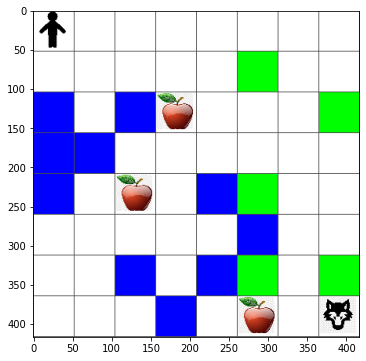

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## اعمال اور پالیسی

ہمارے مثال میں، پیٹر کا مقصد ایک سیب تلاش کرنا ہوگا، جبکہ بھیڑیا اور دیگر رکاوٹوں سے بچنا ہوگا۔ اس کے لیے، وہ بنیادی طور پر چل پھر سکتا ہے جب تک کہ وہ سیب نہ ڈھونڈ لے۔ لہذا، کسی بھی مقام پر وہ درج ذیل اعمال میں سے ایک کا انتخاب کر سکتا ہے: اوپر، نیچے، بائیں اور دائیں۔ ہم ان اعمال کو ایک لغت کے طور پر تعریف کریں گے، اور انہیں متعلقہ کوآرڈینیٹ تبدیلیوں کے جوڑوں سے منسلک کریں گے۔ مثال کے طور پر، دائیں طرف حرکت کرنا (`R`) ایک جوڑے `(1,0)` کے مطابق ہوگا۔


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

ہمارے ایجنٹ (پیٹر) کی حکمت عملی کو ایک خاص **پالیسی** کے ذریعے بیان کیا جاتا ہے۔ آئیے سب سے آسان پالیسی پر غور کریں جسے **رینڈم واک** کہا جاتا ہے۔

## رینڈم واک

آئیے پہلے رینڈم واک حکمت عملی کو نافذ کرکے ہمارا مسئلہ حل کریں۔


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

چلیں بے ترتیب واک کا تجربہ کئی بار کرتے ہیں اور دیکھتے ہیں کہ اوسطاً کتنے قدم اٹھائے گئے:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## انعامی فنکشن

ہماری پالیسی کو زیادہ ذہین بنانے کے لیے، ہمیں یہ سمجھنے کی ضرورت ہے کہ کون سے اقدامات دوسروں کے مقابلے میں "بہتر" ہیں۔


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## کیو لرننگ

ایک کیو-ٹیبل یا کثیر جہتی array بنائیں۔ چونکہ ہمارے بورڈ کے طول و عرض `width` x `height` ہیں، ہم کیو-ٹیبل کو ایک numpy array کے ذریعے ظاہر کر سکتے ہیں جس کی شکل `width` x `height` x `len(actions)` ہو:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Q-Table کو بورڈ پر ٹیبل کو دیکھنے کے لئے plot فنکشن میں پاس کریں۔


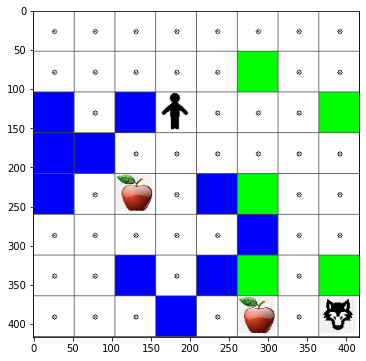

In [9]:
m.plot(Q)

## کیو-لرننگ کا خلاصہ: بیلمن مساوات اور لرننگ الگورتھم

ہمارے لرننگ الگورتھم کے لیے ایک پیسڈو کوڈ لکھیں:

* تمام حالتوں اور اعمال کے لیے Q-Table Q کو برابر نمبروں سے شروع کریں  
* لرننگ ریٹ $\alpha\leftarrow 1$ مقرر کریں  
* سیمولیشن کو کئی بار دہرائیں  
   1. کسی بھی تصادفی مقام سے شروع کریں  
   1. دہرائیں  
        1. حالت $s$ پر ایک عمل $a$ منتخب کریں  
        2. عمل کو انجام دے کر نئی حالت $s'$ پر جائیں  
        3. اگر ہم کھیل کے اختتام کی حالت پر پہنچ جائیں، یا کل انعام بہت کم ہو - سیمولیشن سے باہر نکلیں  
        4. نئی حالت پر انعام $r$ کا حساب لگائیں  
        5. بیلمن مساوات کے مطابق Q-Function کو اپڈیٹ کریں: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$  
        6. $s\leftarrow s'$  
        7. کل انعام کو اپڈیٹ کریں اور $\alpha$ کو کم کریں۔  

## فائدہ اٹھانا بمقابلہ دریافت کرنا

بہترین طریقہ یہ ہے کہ دریافت اور فائدہ اٹھانے کے درمیان توازن رکھا جائے۔ جیسے جیسے ہم اپنے ماحول کے بارے میں زیادہ سیکھتے ہیں، ہم زیادہ امکان رکھتے ہیں کہ بہترین راستے پر چلیں، لیکن کبھی کبھار غیر دریافت شدہ راستے کو بھی منتخب کریں۔

## پائتھون میں عمل درآمد

اب ہم لرننگ الگورتھم کو نافذ کرنے کے لیے تیار ہیں۔ اس سے پہلے، ہمیں ایک فنکشن کی بھی ضرورت ہے جو Q-Table میں موجود کسی بھی عدد کو متعلقہ اعمال کے لیے امکانات کے ویکٹر میں تبدیل کرے:  


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

ہم اصل ویکٹر میں ایک چھوٹا سا `eps` شامل کرتے ہیں تاکہ ابتدائی صورت میں، جب ویکٹر کے تمام اجزاء ایک جیسے ہوں، صفر سے تقسیم سے بچا جا سکے۔

حقیقی سیکھنے کا الگورتھم جسے ہم 5000 تجربات کے لیے چلائیں گے، جسے **epochs** بھی کہا جاتا ہے:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

اس الگورتھم کو چلانے کے بعد، کیو-ٹیبل کو ان اقدار کے ساتھ اپ ڈیٹ کیا جانا چاہئے جو ہر مرحلے پر مختلف اعمال کی کشش کو بیان کرتی ہیں۔ یہاں ٹیبل کو دیکھیں:


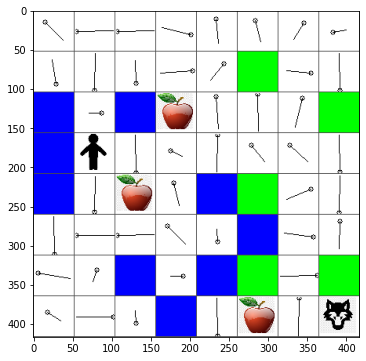

In [12]:
m.plot(Q)

## پالیسی کی جانچ

چونکہ Q-Table ہر حالت میں ہر عمل کی "دلکشی" کو درج کرتا ہے، اس کا استعمال ہماری دنیا میں مؤثر نیویگیشن کی وضاحت کے لیے کافی آسان ہے۔ سب سے آسان صورت میں، ہم صرف اس عمل کو منتخب کر سکتے ہیں جو Q-Table کی سب سے زیادہ قدر سے مطابقت رکھتا ہو:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

اگر آپ اوپر دیا گیا کوڈ کئی بار آزمائیں، تو آپ دیکھ سکتے ہیں کہ بعض اوقات یہ بس "رک" جاتا ہے، اور آپ کو نوٹ بک میں STOP بٹن دباکر اسے روکنا پڑتا ہے۔

> **ٹاسک 1:** `walk` فنکشن میں ترمیم کریں تاکہ راستے کی زیادہ سے زیادہ لمبائی کو ایک مخصوص تعداد کے قدموں (مثال کے طور پر، 100) تک محدود کیا جا سکے، اور اوپر دیا گیا کوڈ وقتاً فوقتاً یہ قدر واپس کرے۔

> **ٹاسک 2:** `walk` فنکشن میں ترمیم کریں تاکہ یہ ان جگہوں پر واپس نہ جائے جہاں یہ پہلے جا چکا ہے۔ یہ `walk` کو لوپنگ سے روکے گا، لیکن ایجنٹ پھر بھی ایسی جگہ پر "پھنس" سکتا ہے جہاں سے وہ باہر نہ نکل سکے۔


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


## سیکھنے کے عمل کی تحقیق


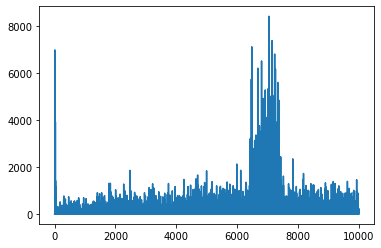

In [15]:
plt.plot(lpath)

جو ہم یہاں دیکھتے ہیں وہ یہ ہے کہ شروع میں اوسط راستے کی لمبائی بڑھ گئی۔ اس کی ممکنہ وجہ یہ ہے کہ جب ہمیں ماحول کے بارے میں کچھ معلوم نہیں ہوتا - تو ہم ممکنہ طور پر خراب حالتوں، پانی یا بھیڑیے میں پھنس سکتے ہیں۔ جیسے جیسے ہم زیادہ سیکھتے ہیں اور اس علم کو استعمال کرتے ہیں، ہم ماحول کو زیادہ دیر تک تلاش کر سکتے ہیں، لیکن ہمیں ابھی بھی یہ اچھی طرح معلوم نہیں ہوتا کہ سیب کہاں ہیں۔

جب ہم کافی سیکھ لیتے ہیں، تو ایجنٹ کے لیے مقصد حاصل کرنا آسان ہو جاتا ہے، اور راستے کی لمبائی کم ہونے لگتی ہے۔ تاہم، ہم ابھی بھی تلاش کے لیے کھلے ہیں، اس لیے ہم اکثر بہترین راستے سے ہٹ جاتے ہیں اور نئے اختیارات تلاش کرتے ہیں، جس سے راستہ مثالی سے زیادہ لمبا ہو جاتا ہے۔

جو ہم اس گراف پر مزید دیکھتے ہیں، وہ یہ ہے کہ کسی وقت راستے کی لمبائی اچانک بڑھ گئی۔ یہ عمل کی غیر یقینی نوعیت کو ظاہر کرتا ہے، اور یہ کہ ہم کسی وقت Q-Table coefficients کو خراب کر سکتے ہیں، انہیں نئے اقدار سے اوور رائٹ کر کے۔ اس کو کم سے کم کرنے کے لیے سیکھنے کی شرح کو کم کرنا ضروری ہے (یعنی تربیت کے آخر میں ہم Q-Table کی اقدار کو صرف تھوڑا سا ایڈجسٹ کرتے ہیں)۔

مجموعی طور پر، یہ یاد رکھنا ضروری ہے کہ سیکھنے کے عمل کی کامیابی اور معیار کا انحصار مختلف پیرامیٹرز پر ہوتا ہے، جیسے سیکھنے کی شرح، سیکھنے کی شرح میں کمی، اور ڈسکاؤنٹ فیکٹر۔ انہیں اکثر **ہائپرپیرامیٹرز** کہا جاتا ہے، تاکہ انہیں **پیرامیٹرز** سے الگ کیا جا سکے جنہیں ہم تربیت کے دوران بہتر کرتے ہیں (جیسے Q-Table coefficients)۔ بہترین ہائپرپیرامیٹرز کی اقدار تلاش کرنے کے عمل کو **ہائپرپیرامیٹر آپٹیمائزیشن** کہا جاتا ہے، اور یہ ایک الگ موضوع کا مستحق ہے۔


## مشق  
#### ایک زیادہ حقیقی "پیٹر اینڈ دی وولف" دنیا  

ہمارے منظرنامے میں، پیٹر تقریباً بغیر تھکے یا بھوکے ہوئے ادھر ادھر گھوم سکتا تھا۔ ایک زیادہ حقیقی دنیا میں، اسے وقتاً فوقتاً بیٹھ کر آرام کرنا ہوگا اور خود کو کھلانا بھی ہوگا۔ آئیے اپنی دنیا کو زیادہ حقیقی بناتے ہیں اور درج ذیل اصول نافذ کرتے ہیں:  

1. ایک جگہ سے دوسری جگہ جانے پر، پیٹر کی **توانائی** کم ہوتی ہے اور اسے کچھ **تھکن** ہو جاتی ہے۔  
2. پیٹر سیب کھا کر مزید توانائی حاصل کر سکتا ہے۔  
3. پیٹر درخت کے نیچے یا گھاس پر آرام کرکے تھکن دور کر سکتا ہے (یعنی ایسی جگہ پر جانا جہاں درخت یا گھاس ہو - سبز میدان)۔  
4. پیٹر کو بھیڑیا تلاش کرکے اسے مارنا ہوگا۔  
5. بھیڑیا مارنے کے لیے، پیٹر کے پاس توانائی اور تھکن کے مخصوص درجے ہونے چاہئیں، ورنہ وہ جنگ ہار جائے گا۔  

اوپر دی گئی انعامی فنکشن کو کھیل کے اصولوں کے مطابق تبدیل کریں، تقویت یافتہ سیکھنے کا الگورتھم چلائیں تاکہ کھیل جیتنے کی بہترین حکمت عملی سیکھی جا سکے، اور تصادفی چال کے نتائج کا اپنے الگورتھم کے ساتھ موازنہ کریں، جیتے اور ہارے گئے کھیلوں کی تعداد کے لحاظ سے۔  

> **نوٹ**: آپ کو اسے کام کرنے کے لیے ہائپرپیرامیٹرز کو ایڈجسٹ کرنے کی ضرورت ہو سکتی ہے، خاص طور پر ایپوکز کی تعداد۔ کیونکہ کھیل کی کامیابی (بھیڑیا سے لڑائی) ایک نایاب واقعہ ہے، آپ زیادہ طویل تربیتی وقت کی توقع کر سکتے ہیں۔  



---

**ڈس کلیمر**:  
یہ دستاویز AI ترجمہ سروس [Co-op Translator](https://github.com/Azure/co-op-translator) کا استعمال کرتے ہوئے ترجمہ کی گئی ہے۔ ہم درستگی کے لیے پوری کوشش کرتے ہیں، لیکن براہ کرم آگاہ رہیں کہ خودکار ترجمے میں غلطیاں یا عدم درستگی ہو سکتی ہیں۔ اصل دستاویز کو اس کی اصل زبان میں مستند ذریعہ سمجھا جانا چاہیے۔ اہم معلومات کے لیے، پیشہ ور انسانی ترجمہ کی سفارش کی جاتی ہے۔ اس ترجمے کے استعمال سے پیدا ہونے والی کسی بھی غلط فہمی یا غلط تشریح کے لیے ہم ذمہ دار نہیں ہیں۔
